# Importing Libraries

In [26]:
#for eda
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import numpy as np

import random as rd
import scipy
import scipy.stats as stats
from sklearn.linear_model import SGDClassifier

# Helping Functions

In [27]:
def systematic_sample(df, size):
    length = len(df)
    interval = length // size
    rd.seed(None)
    first = rd.randint(0, interval)
    indexes = np.arange(first, length, step = interval)
    return df.iloc[indexes]

In [28]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [29]:
def convert_categorical_to_numerical(df):
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Check if there are any categorical columns
    if not categorical_cols:
        print("No categorical columns found.")
        return df

    # Create a new DataFrame with categorical columns converted to numerical using one-hot encoding
    df_numerical = pd.get_dummies(df, columns=categorical_cols, dtype='float')

    return df_numerical



In [30]:
def get_features_and_labels(df, label_column):
    # Identify feature columns
    feature_cols = df.columns[df.columns != label_column]

    # Create X_train with features
    X_train = df[feature_cols]

    # Create Y_train with the specified label column
    Y_train = df[label_column]

    return X_train, Y_train


In [31]:
def check_certain_model(X_train, y_train):
    res = True
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()

    # Convert X_train and y_train to NumPy arrays
    X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y_train = y_train.values if isinstance(y_train, pd.DataFrame) or isinstance(y_train, pd.Series) else y_train

    # Find indices of columns with missing values in X_train
    missing_columns_indices = np.where(pd.DataFrame(X_train).isnull().any(axis=0))[0]

    # Find rows with missing values in X_train
    missing_rows_indices = np.where(pd.DataFrame(X_train).isnull().any(axis=1))[0]

    # Record the rows with missing values and their corresponding y_train values
    X_train_missing_rows = X_train[missing_rows_indices]
    y_train_missing_rows = y_train[missing_rows_indices]

    # Remove rows with missing values from X_train and corresponding labels from y_train
    X_train_complete = np.delete(X_train, missing_rows_indices, axis=0)
    y_train_complete = np.delete(y_train, missing_rows_indices, axis=0)


    print(f"Original shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Shape after removal: X_train: {X_train_complete.shape}, y_train: {y_train_complete.shape}")

    # Create and train the SVM model using SGDClassifier
    svm_model = SGDClassifier(loss='hinge', max_iter=1000, random_state=42)

    # Train the model on the data without missing values
    svm_model.fit(X_train_complete, y_train_complete)

    # Extract the feature weights (model parameters)
    feature_weights = svm_model.coef_[0]

    # Check if the absolute value of feature_weights[i] is small enough for all i with missing columns
    for i in missing_columns_indices:
        if abs(feature_weights[i]) >= 1e-3:
            res = False
            print("weight", feature_weights[i])
            break
            # Return False as soon as a condition is not met

    # Check the condition for all rows in X_train_missing_rows
    for i in range(len(X_train_missing_rows)):
        row = X_train_missing_rows[i]
        label = y_train_missing_rows[i]
        dot_product = np.sum(row[~np.isnan(row)] * feature_weights[~np.isnan(row)])
        if label * dot_product <= 1:
            print("dot product", label * dot_product)
            res = False
            break
            # Return False if the condition is not met for any row

    # If all conditions are met, return True
    return res, feature_weights

In [32]:
def check_orthogonal(M,l):
    flag = True
    case = ''
    for i in range(M.shape[1]):
        total = 0
        for j in range(len(l)):
            if np.isnan(M.iloc[j,i]) and not np.isclose(l[j], 0,atol=1e-03):
                flag = False
                case = 'case1: ' + str(l[j])
                break
            elif not np.isnan(M.iloc[j,i]):
                #print(f'inside case2 : M:{M.iloc[j,i]}, l:{l[j]}')
                total += M.iloc[j,i] * l[j]
        if not np.isclose(total ,0, atol = 1e-03):
            flag = False
            case = 'case2: ' + str(total)
            break
    #print(case)
    return flag

def check_certain_model_regression(CX_train, Cy_train, missing_train, CX_test, Cy_test, missing_test):
    #reg = SGDRegressor(penalty = None).fit(CX,Cy)
    reg = LinearRegression(fit_intercept = False).fit(CX_train,Cy_train)
    w_bar = reg.coef_
    loss = (np.dot(CX_test,w_bar.T) - Cy_test)
    result = check_orthogonal(missing_test,loss)
    # print('w_bar',w_bar)
    # print('loss',loss)
    return result, reg.score(CX_test,Cy_test)

# Titanic Data Set

In [33]:
titanic_train_df = pd.read_csv("/kaggle/input/titanic/train.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/titanic/train.csv'

In [26]:
systematic_sample(titanic_train_df, 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
103,104,0,3,"Johansson, Mr. Gustaf Joel",male,33.000,0,0,7540,8.654,NaN,S
281,282,0,3,"Olsson, Mr. Nils Johan Goransson",male,28.000,0,0,347464,7.854,NaN,S
459,460,0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.750,NaN,Q
637,638,0,2,"Collyer, Mr. Harvey",male,31.000,1,1,C.A. 31921,26.250,NaN,S
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.000,B102,S


In [27]:
missing_values_table(titanic_train_df)

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.100
Age,177,19.900
Embarked,2,0.200


<Axes: >

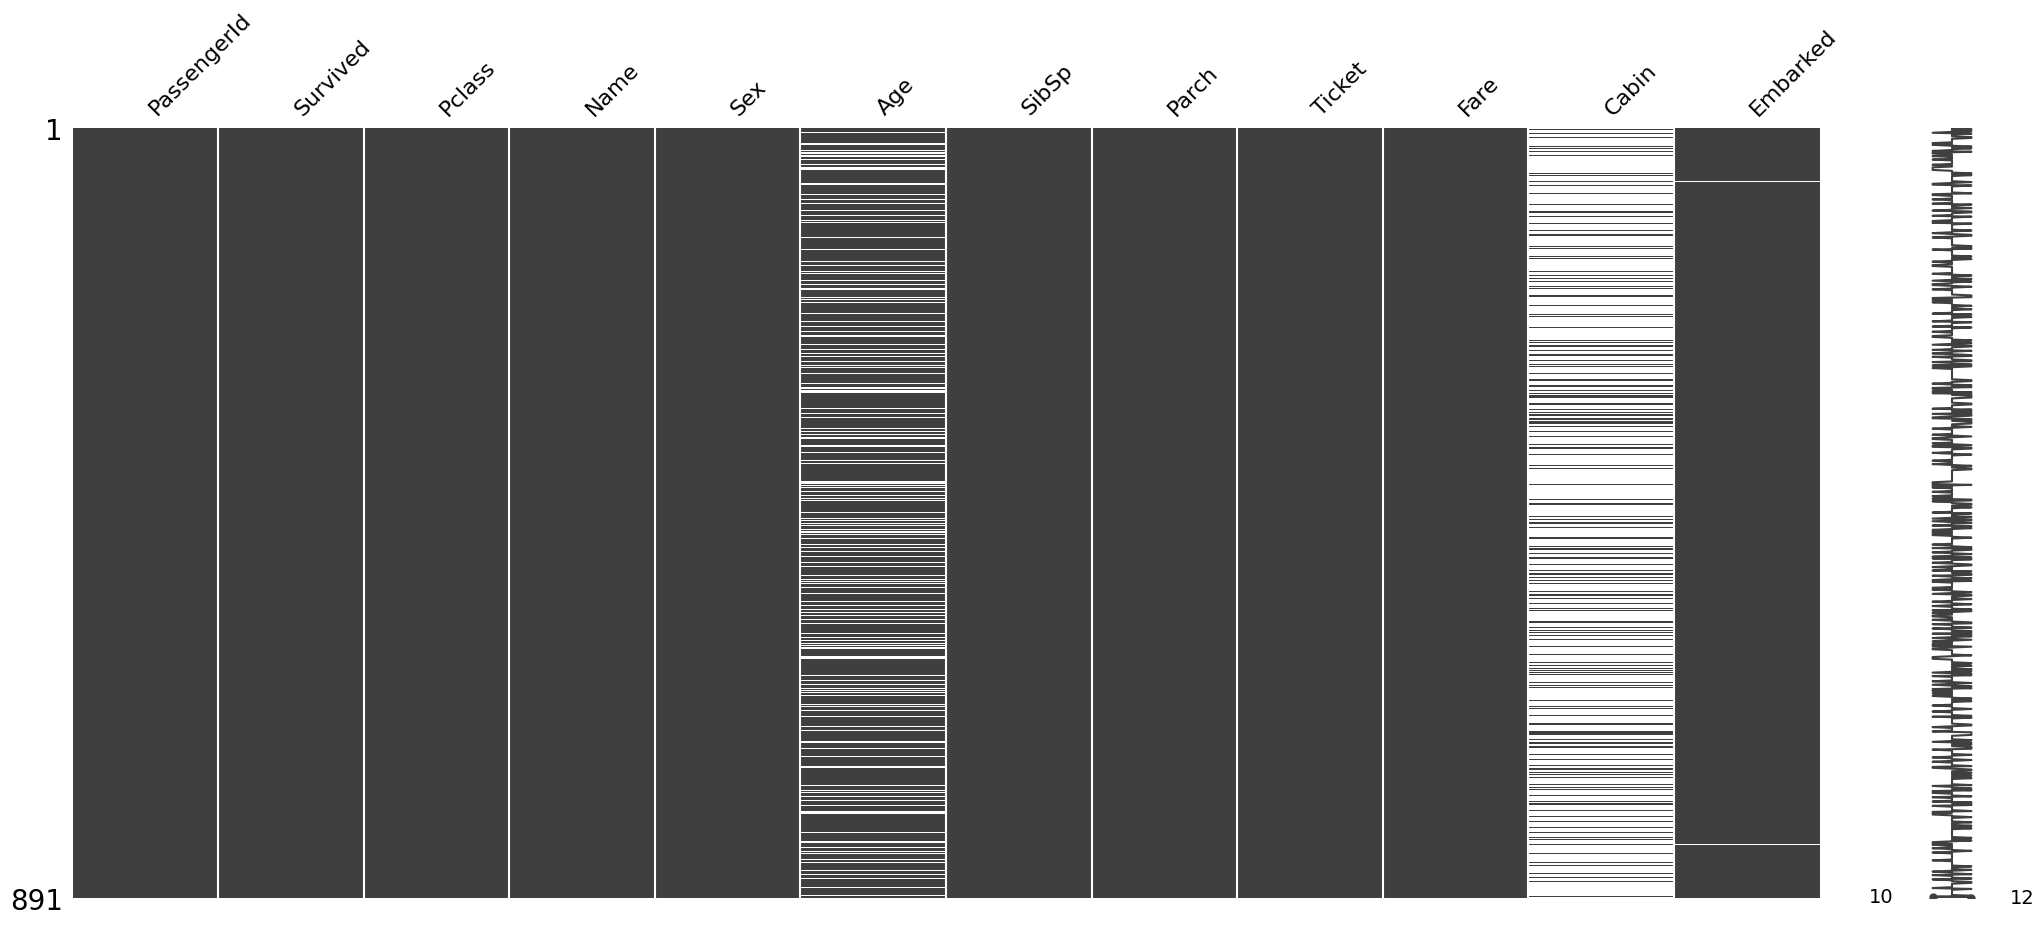

In [28]:
msno.matrix(titanic_train_df)

<Axes: >

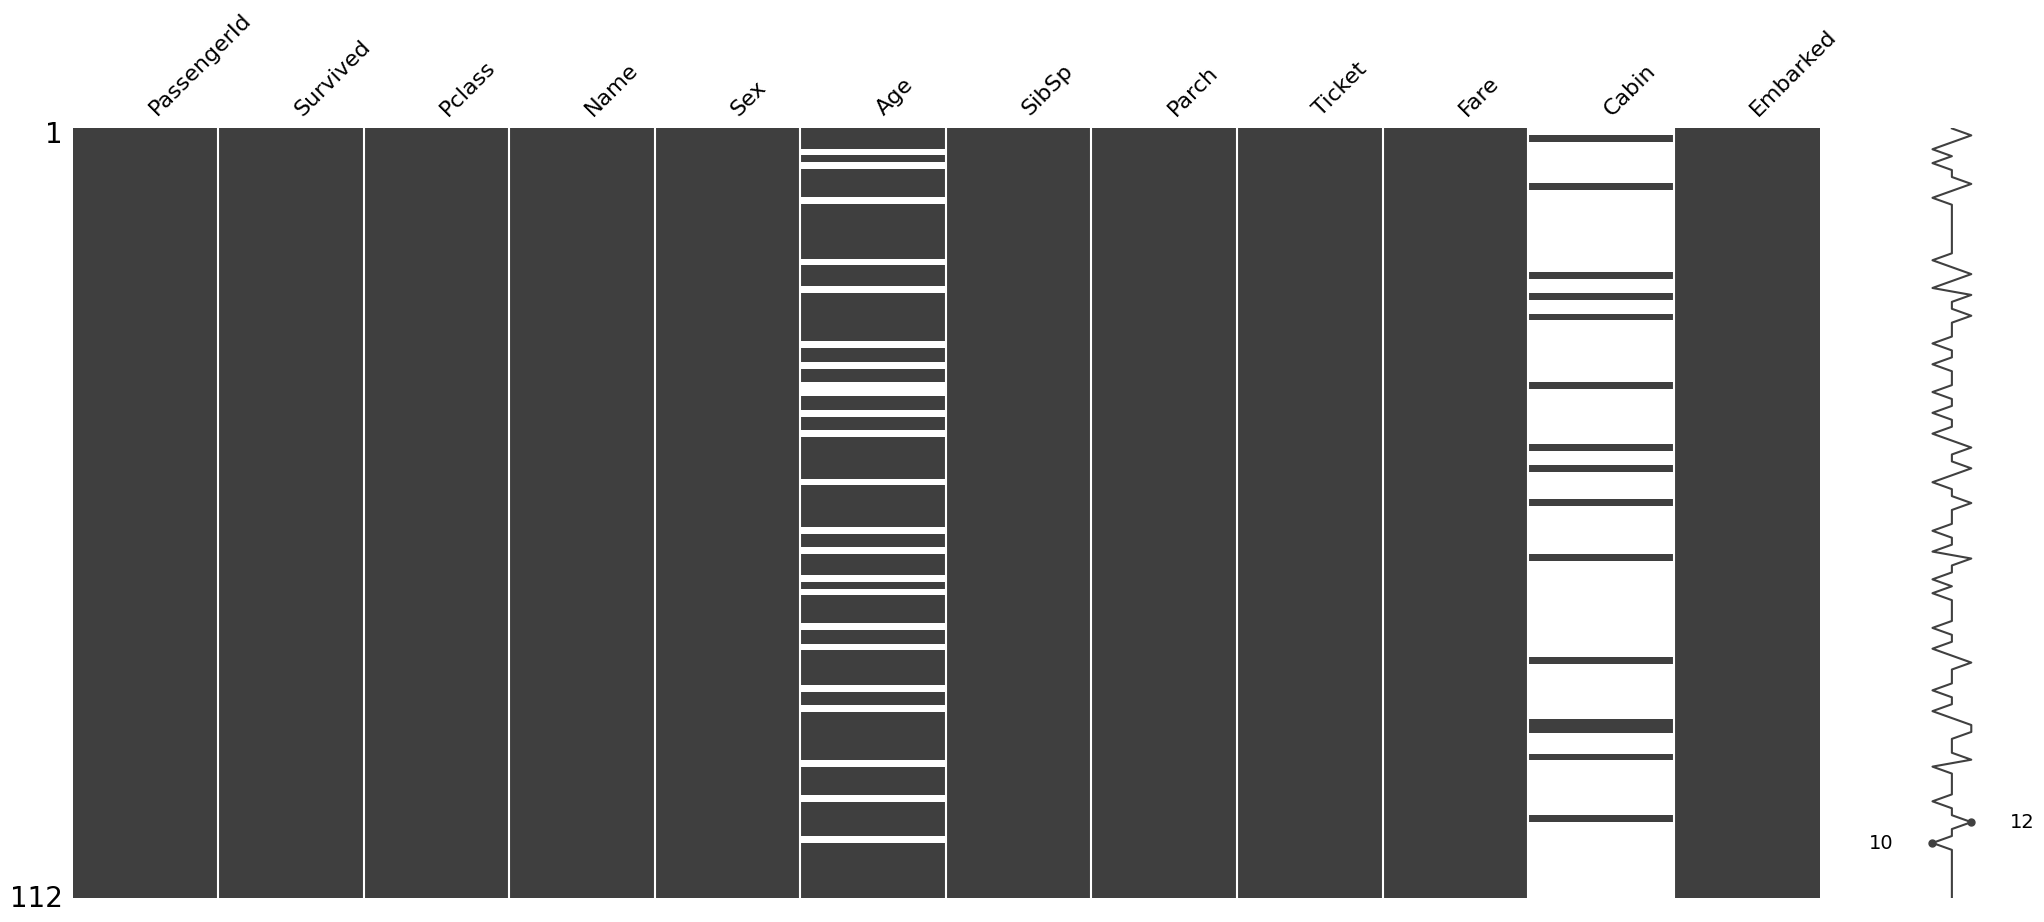

In [55]:
msno.matrix(systematic_sample(titanic_train_df, 100))

In [56]:

# Example usage
# Assuming titanic_train_df is your original DataFrame
titanic_train_df_numerical = convert_categorical_to_numerical(titanic_train_df)
systematic_sample(titanic_train_df_numerical, 5)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,"Name_Abbing, Mr. Anthony","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen-Jensen, Miss. Carla Christine Nielsine","Name_Anderson, Mr. Harry","Name_Andersson, Master. Sigvard Harald Elias","Name_Andersson, Miss. Ebba Iris Alfrida","Name_Andersson, Miss. Ellis Anna Maria","Name_Andersson, Miss. Erna Alexandra","Name_Andersson, Miss. Ingeborg Constanzia","Name_Andersson, Miss. Sigrid Elisabeth","Name_Andersson, Mr. Anders Johan","Name_Andersson, Mr. August Edvard (""Wennerstrom"")","Name_Andersson, Mrs. Anders Johan (Alfrida Konstantia Brogren)","Name_Andreasson, Mr. Paul Edvin","Name_Andrew, Mr. Edgardo Samuel","Name_Andrews, Miss. Kornelia Theodosia","Name_Andrews, Mr. Thomas Jr","Name_Angle, Mrs. William A (Florence ""Mary"" Agnes Hughes)","Name_Appleton, Mrs. Edward Dale (Charlotte Lamson)","Name_Arnold-Franchi, Mr. Josef","Name_Arnold-Franchi, Mrs. Josef (Josefine Franchi)","Name_Artagaveytia, Mr. Ramon","Name_Asim, Mr. Adola","Name_Asplund, Master. Clarence Gustaf Hugo","Name_Asplund, Master. Edvin Rojj Felix","Name_Asplund, Miss. Lillian Gertrud","Name_Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)","Name_Astor, Mrs. John Jacob (Madeleine Talmadge Force)","Name_Attalah, Miss. Malake","Name_Attalah, Mr. Sleiman","Name_Aubart, Mme. Leontine Pauline","Name_Augustsson, Mr. Albert","Name_Ayoub, Miss. Banoura","Name_Backstrom, Mr. Karl Alfred","Name_Backstrom, Mrs. Karl Alfred (Maria Mathilda Gustafsson)","Name_Baclini, Miss. Eugenie","Name_Baclini, Miss. Helene Barbara","Name_Baclini, Miss. Marie Catherine","Name_Baclini, Mrs. Solomon (Latifa Qurban)","Name_Badt, Mr. Mohamed","Name_Bailey, Mr. Percy Andrew","Name_Balkic, Mr. Cerin","Name_Ball, Mrs. (Ada E Hall)","Name_Banfield, Mr. Frederick James","Name_Barah, Mr. Hanna Assi","Name_Barbara, Miss. Saiide","Name_Barbara, Mrs. (Catherine David)","Name_Barber, Miss. Ellen ""Nellie""","Name_Barkworth, Mr. Algernon Henry Wilson","Name_Barton, Mr. David John","Name_Bateman, Rev. Robert James","Name_Baumann, Mr. John D","Name_Baxter, Mr. Quigg Edmond","Name_Baxter, Mrs. James (Helene DeLaudeniere Chaput)","Name_Bazzani, Miss. Albina","Name_Beane, Mr. Edward","Name_Beane, Mrs. Edward (Ethel Clarke)","Name_Beavan, Mr. William Thomas","Name_Becker, Master. Richard F","Name_Becker, Miss. Marion Louise","Name_Beckwith, Mr. Richard Leonard","Name_Beckwith, Mrs. Richard Leonard (Sallie Monypeny)","Name_Beesley, Mr. Lawrence","Name_Behr, Mr. Karl Howell","Name_Bengtsson, Mr. John Viktor","Name_Berglund, Mr. Karl Ivar Sven","Name_Berriman, Mr. William John","Name_Betros, Mr. Tannous","Name_Bidois, Miss. Rosalie","Name_Bing, Mr. Lee","Name_Birkeland, Mr. Hans Martin Monsen","Name_Bishop, Mr. Dickinson H","Name_Bishop, Mrs. Dickinson H (Helen Walton)","Name_Bissette, Miss. Amelia","Name_Bjornstrom-Steffansson, Mr. Mauritz Hakan","Name_Blackwell, Mr. Stephen Weart","Name_Blank, Mr. Henry","Name_Bonnell, Miss. Elizabeth","Name_Bostandyeff, Mr. Guentcho","Name_Boulos, Miss. Nourelain","Name_Boulos, Mr. Hanna","Name_Boulos, Mrs. Joseph (Sultana)","Name_Bourke, Miss. Mary","Name_Bourke, Mr. John","Name_Bourke, Mrs. John (Catherine)","Name_Bowen, Mr. David John ""Dai""","Name_Bowerman, Miss. Elsie Edith","Name_Bracken, Mr. James H","Name_Bradley, Mr. George (""George Arthur Brayton"")","Name_Braund, Mr. Lewis Richar

In [57]:
titanic_train_df_numerical.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Age            float64
SibSp            int64
                ...   
Cabin_G6       float64
Cabin_T        float64
Embarked_C     float64
Embarked_Q     float64
Embarked_S     float64
Length: 1731, dtype: object

In [ ]:
# Specify the label column
label_column = 'Survived'

# Apply the function
X_train, Y_train = get_features_and_labels(titanic_train_df_numerical, label_column)
print(systematic_sample(X_train, 1))
print("-----------------------------")
print(systematic_sample(Y_train, 1))

In [59]:
check_certain_model(X_train, Y_train)

Original shape: X_train: (891, 1730), y_train: (891,)
Shape after removal: X_train: (714, 1730), y_train: (714,)
weight -241.84816361494237
dot product -0.0


(False,
 array([  89.08876753, -762.60841632, -241.84816361, ...,  170.89624157,
         -34.47906628, -161.47339116]))

# Air Quality Data in India Data Set

In [9]:
city_day_df = pd.read_csv('data/city_day.csv',parse_dates=True,index_col='Date')

In [10]:
systematic_sample(city_day_df, 5)

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2017-04-30,Amritsar,25.810,NaN,15.620,16.070,NaN,28.300,0.000,5.270,13.020,NaN,NaN,NaN,43.000,Good
2018-04-22,Chennai,31.220,NaN,10.760,20.920,15.300,28.550,0.800,3.780,32.970,1.130,6.300,NaN,55.000,Satisfactory
2016-01-05,Hyderabad,80.830,113.230,9.040,16.650,24.060,10.550,1.210,8.870,34.370,1.570,9.390,0.970,218.000,Poor
2017-10-04,Lucknow,42.050,NaN,8.890,25.470,23.200,9.520,0.960,7.040,20.420,2.490,7.570,NaN,100.000,Satisfactory
2019-12-17,Talcher,61.900,197.760,8.400,35.980,40.510,NaN,1.890,4.650,20.720,0.000,NaN,NaN,161.000,Moderate


In [11]:
missing_values_table(city_day_df)

Your selected dataframe has 15 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,18109,61.300
PM10,11140,37.700
NH3,10328,35.000
Toluene,8041,27.200
Benzene,5623,19.000
AQI,4681,15.900
AQI_Bucket,4681,15.900
PM2.5,4598,15.600
NOx,4185,14.200
O3,4022,13.600


<Axes: >

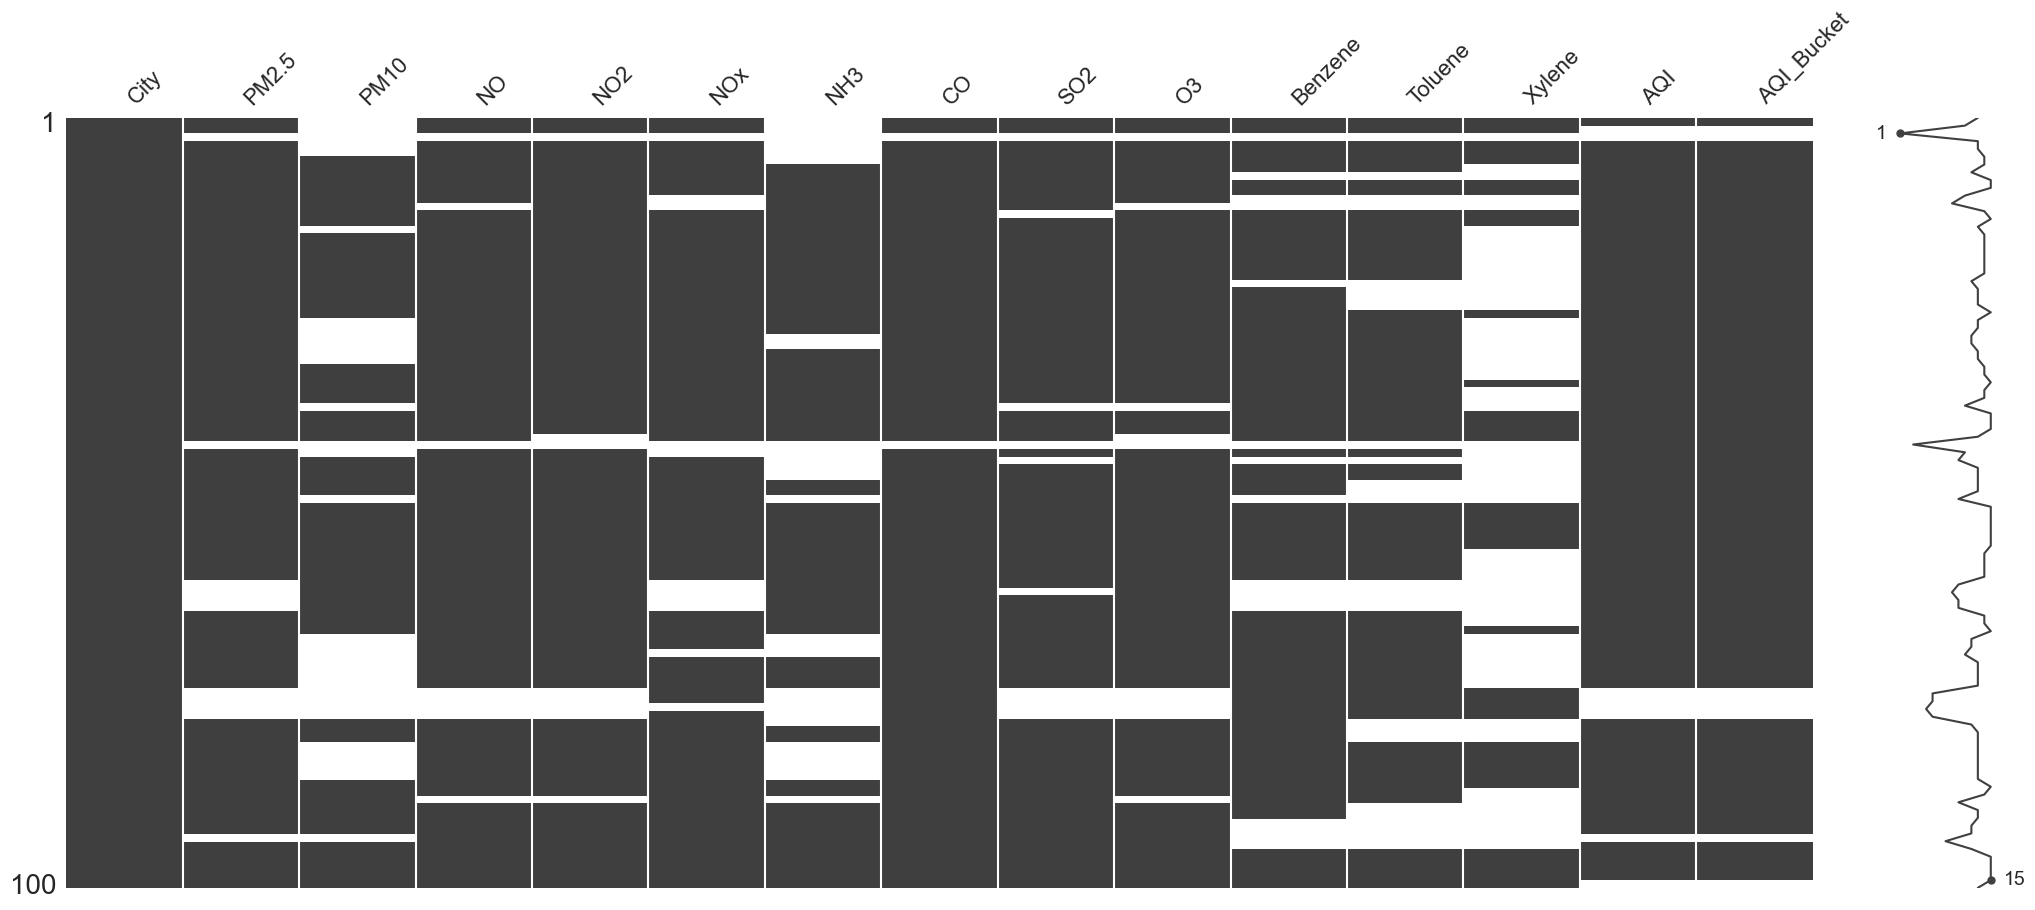

In [12]:
msno.matrix(systematic_sample(city_day_df, 100))

In [13]:
# Example usage
# Assuming titanic_train_df is your original DataFrame
city_day_df_numerical = convert_categorical_to_numerical(city_day_df)
systematic_sample(city_day_df_numerical, 5)


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,City_Ahmedabad,City_Aizawl,City_Amaravati,City_Amritsar,City_Bengaluru,City_Bhopal,City_Brajrajnagar,City_Chandigarh,City_Chennai,City_Coimbatore,City_Delhi,City_Ernakulam,City_Gurugram,City_Guwahati,City_Hyderabad,City_Jaipur,City_Jorapokhar,City_Kochi,City_Kolkata,City_Lucknow,City_Mumbai,City_Patna,City_Shillong,City_Talcher,City_Thiruvananthapuram,City_Visakhapatnam,AQI_Bucket_Good,AQI_Bucket_Moderate,AQI_Bucket_Poor,AQI_Bucket_Satisfactory,AQI_Bucket_Severe,AQI_Bucket_Very Poor
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-05-20,42.310,118.650,17.470,81.840,59.840,NaN,17.470,89.570,46.680,15.980,83.870,13.600,813.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2020-06-08,77.380,144.410,14.480,0.610,15.030,3.030,0.640,6.880,74.930,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-09-04,48.540,NaN,14.310,23.850,21.830,NaN,0.290,7.030,10.580,1.790,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2019-01-21,266.100,419.430,155.980,103.210,237.220,54.250,2.320,19.000,27.810,31.870,44.060,NaN,425.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2019-02-20,150.620,NaN,15.930,39.140,19.810,NaN,1.790,45.960,55.670,2.340,19.370,7.770,330.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [24]:
# Specify the label column
label_column = 'City_Aizawl'

# Apply the function
X_train, Y_train = get_features_and_labels(city_day_df_numerical, label_column)
print(systematic_sample(X_train, 1))
print("-----------------------------")
print(systematic_sample(Y_train, 1))

            PM2.5  PM10      NO    NO2    NOx  NH3      CO    SO2    O3  \
Date                                                                      
2015-01-11    NaN   NaN 132.070 55.800 24.530  NaN 132.070 25.030 6.790   

            Benzene  Toluene  Xylene  AQI  City_Ahmedabad  City_Amaravati  \
Date                                                                        
2015-01-11    0.000    0.000   0.000  NaN           1.000           0.000   

            City_Amritsar  City_Bengaluru  City_Bhopal  City_Brajrajnagar  \
Date                                                                        
2015-01-11          0.000           0.000        0.000              0.000   

            City_Chandigarh  City_Chennai  City_Coimbatore  City_Delhi  \
Date                                                                     
2015-01-11            0.000         0.000            0.000       0.000   

            City_Ernakulam  City_Gurugram  City_Guwahati  City_Hyderabad  \
Date       

In [25]:
check_certain_model(X_train, Y_train)

Original shape: X_train: (29531, 44), y_train: (29531,)
Shape after removal: X_train: (6236, 44), y_train: (6236,)


ValueError: The number of classes has to be greater than one; got 1 class

# San Francisco Building Permits

In [70]:
buildings_df = pd.read_csv("/kaggle/input/building-permit-applications-data/Building_Permits.csv")

In [71]:
systematic_sample(buildings_df, 5)

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
12459,201305146842,8,otc alterations permit,05/14/2013,1186,018A,1785,NaN,Fulton,St,NaN,NaN,voluntary building strengthening including new...,complete,04/07/2014,05/14/2013,05/22/2013,04/07/2014,05/22/2013,NaN,3.000,3.000,NaN,NaN,05/17/2014,7500.000,15000.000,food/beverage hndlng,0.000,food/beverage hndlng,0.000,2.000,NaN,5.000,wood frame (5),5.000,wood frame (5),NaN,5.000,Lone Mountain/USF,94117.000,"(37.77569333235999, -122.44603056587363)",1304646381509
52239,201406249189,8,otc alterations permit,06/24/2014,1305,023,115,NaN,Seacliff,Av,NaN,NaN,replace damaged flue w/ class a triple wall fl...,complete,06/27/2014,06/24/2014,06/24/2014,06/27/2014,06/24/2014,NaN,2.000,2.000,NaN,NaN,06/19/2015,7400.000,7400.000,1 family dwelling,1.000,1 family dwelling,1.000,0.000,NaN,5.000,wood frame (5),5.000,wood frame (5),NaN,2.000,Seacliff,94121.000,"(37.788521932480506, -122.48729456406298)",134630795803
92019,201507141441,8,otc alterations permit,07/14/2015,1660,018,785,NaN,17th,Av,NaN,NaN,install (8) vinyl retrofit. windows not visibl...,issued,07/14/2015,07/14/2015,07/14/2015,NaN,07/14/2015,NaN,2.000,2.000,NaN,NaN,07/08/2016,6008.000,6008.000,2 family dwelling,2.000,2 family dwelling,2.000,0.000,NaN,5.000,wood frame (5),5.000,wood frame (5),NaN,1.000,Outer Richmond,94121.000,"(37.773294659482644, -122.47590834745861)",1388366466199
131799,M709087,8,otc alterations permit,07/28/2016,3576,011,2172,NaN,Mission,St,NaN,NaN,street space,issued,07/28/2016,07/28/2016,07/28/2016,NaN,07/28/2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000,Mission,94110.000,"(37.76224388820184, -122.41968415995419)",1431729159406
171579,201501095344,8,otc alterations permit,01/09/2015,0088,029,533,NaN,Greenwich,St,NaN,NaN,installation of new fire sprinkler system for ...,complete,01/16/2018,01/09/2015,01/12/2015,01/16/2018,01/12/2015,NaN,4.000,4.000,NaN,Y,01/07/2016,15000.000,18000.000,apartments,3.000,apartments,3.000,2.000,NaN,5.000,wood frame (5),5.000,wood frame (5),NaN,3.000,North Beach,94133.000,"(37.802150054841384, -122.40848406017508)",1367261231158


In [72]:
missing_values_table(buildings_df)

Your selected dataframe has 43 columns.
There are 31 columns that have missing values.


,Missing Values,% of Total Values
TIDF Compliance,198898,100.000
Voluntary Soft-Story Retrofit,198865,100.000
Unit Suffix,196939,99.000
Street Number Suffix,196684,98.900
Site Permit,193541,97.300
Structural Notification,191978,96.500
Fire Only Permit,180073,90.500
Unit,169421,85.200
Completed Date,101709,51.100
Permit Expiration Date,51880,26.100


<Axes: >

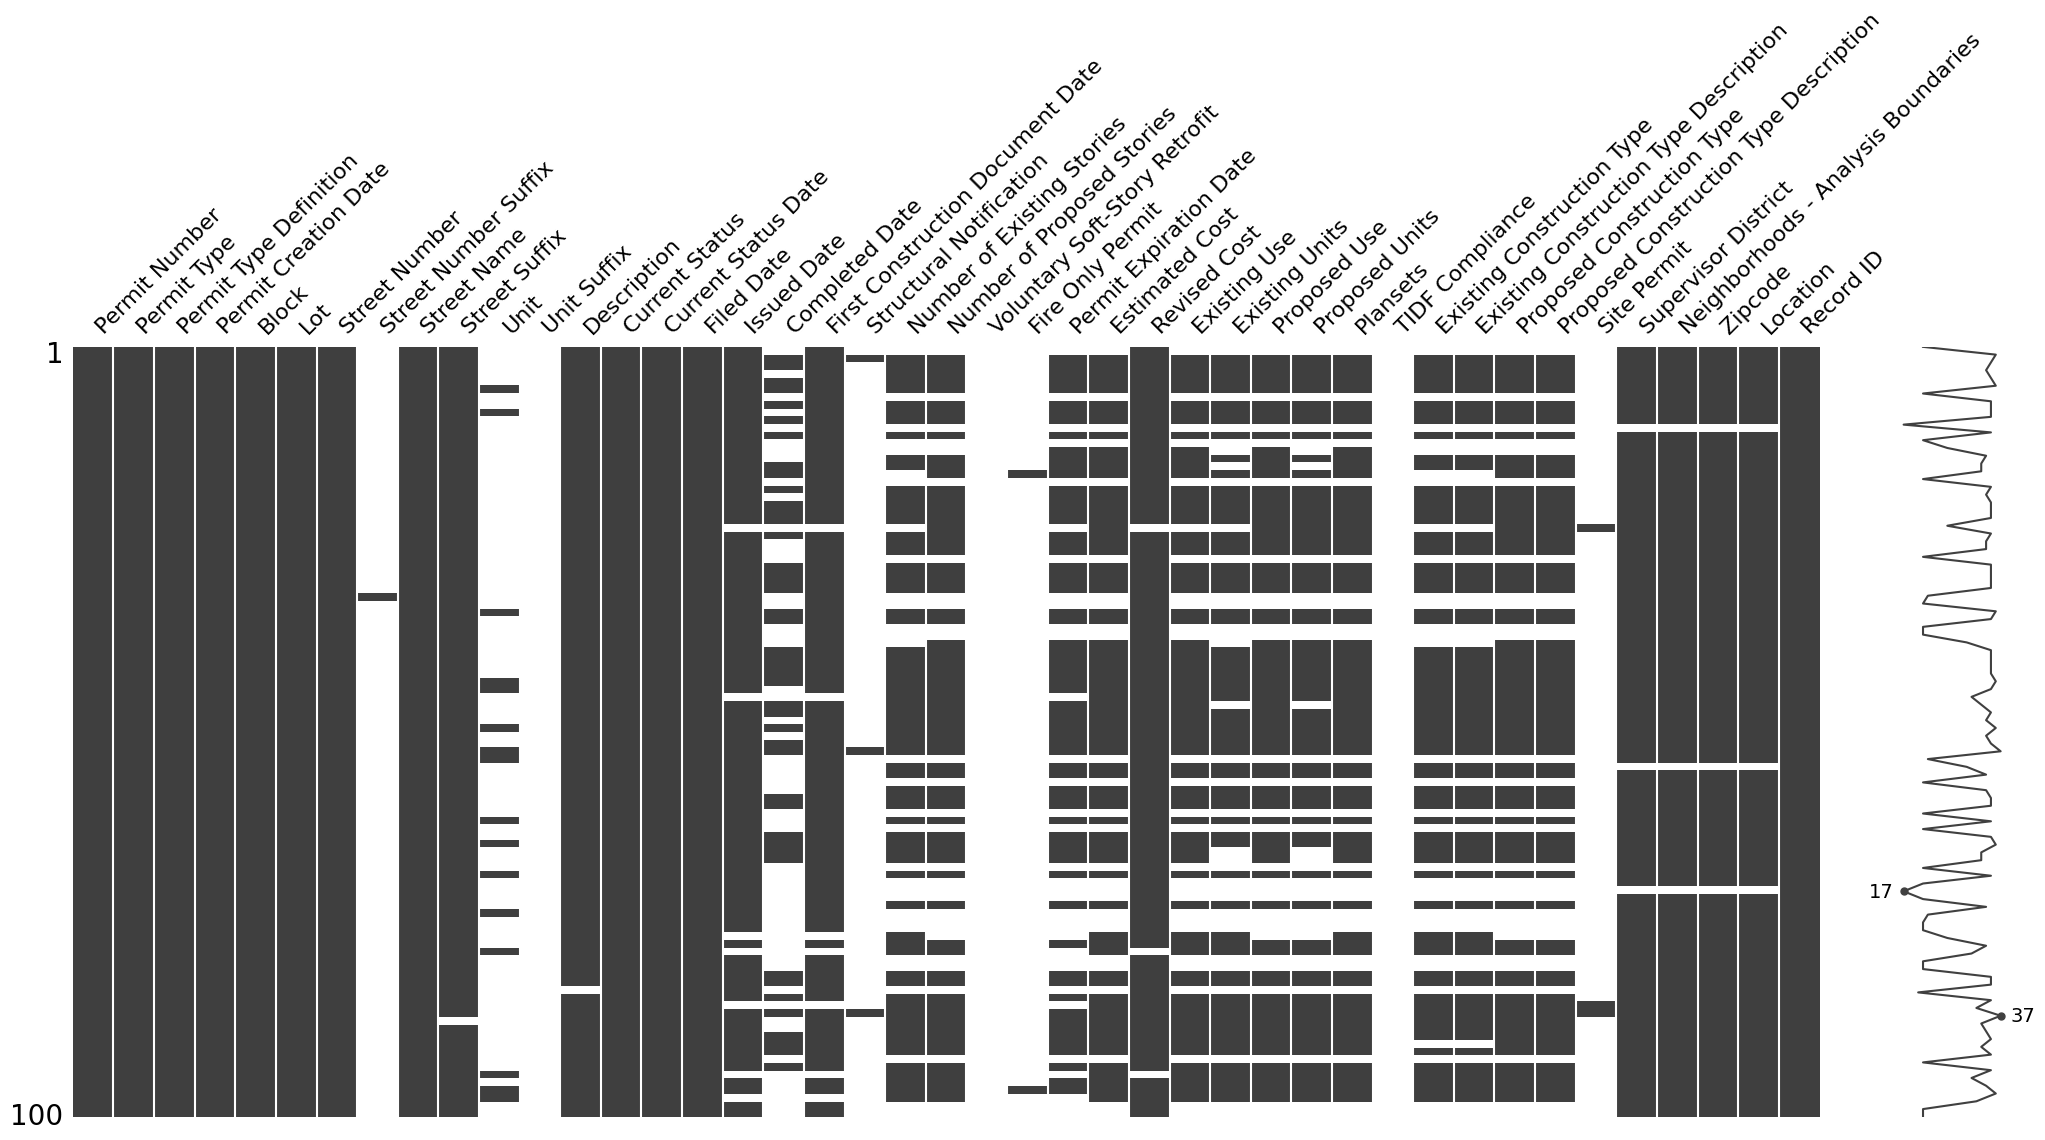

In [73]:
msno.matrix(systematic_sample(buildings_df, 100))

In [ ]:
msno.matrix(buildings_df)

In [ ]:
buildings_df_numerical = convert_categorical_to_numerical(buildings_df)
systematic_sample(buildings_df_numerical, 5)


In [ ]:
# Specify the label column
label_column = 'AQI_Bucket_Severe'

# Apply the function
X_train, Y_train = get_features_and_labels(buildings_df_numerical, label_column)
print(systematic_sample(X_train, 1))
print("-----------------------------")
print(systematic_sample(Y_train, 1))
check_certain_model(X_train, Y_train)

# Detailed NFL Play-by-Play Data 2009-2018

In [8]:
nfl_df = pd.read_csv("/kaggle/input/nflplaybyplay2009to2016/NFL Play by Play 2009-2016 (v3).csv")

In [9]:
systematic_sample(nfl_df, 5)

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,yrdln,yrdline100,ydstogo,ydsnet,GoalToGo,FirstDown,posteam,DefensiveTeam,desc,PlayAttempted,Yards.Gained,sp,Touchdown,ExPointResult,TwoPointConv,DefTwoPoint,Safety,Onsidekick,PuntResult,PlayType,Passer,Passer_ID,PassAttempt,PassOutcome,PassLength,AirYards,YardsAfterCatch,QBHit,PassLocation,InterceptionThrown,Interceptor,Rusher,Rusher_ID,RushAttempt,RunLocation,RunGap,Receiver,Receiver_ID,Reception,ReturnResult,Returner,BlockingPlayer,Tackler1,Tackler2,FieldGoalResult,FieldGoalDistance,Fumble,RecFumbTeam,RecFumbPlayer,Sack,Challenge.Replay,ChalReplayResult,Accepted.Penalty,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,HomeTeam,AwayTeam,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,No_Score_Prob,Opp_Field_Goal_Prob,Opp_Safety_Prob,Opp_Touchdown_Prob,Field_Goal_Prob,Safety_Prob,Touchdown_Prob,ExPoint_Prob,TwoPoint_Prob,ExpPts,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
48026,2010-09-19,2010091907,19,4,4.000,09:52,10,592.000,6.000,ARI,48.000,52.000,6,27,0.000,1.000,ARI,ATL,"(9:52) B.Graham punts 32 yards to ATL 20, Cent...",1,0,0,0,NaN,NaN,NaN,0,0,Clean,Punt,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,Fair Catch,E.Weems,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,7.000,34.000,-27.000,27.000,ATL,ARI,0,NaN,2,2,2,2,2,0.137,0.161,0.002,0.236,0.254,0.005,0.204,0.000,0.000,0.061,-0.639,NaN,NaN,0.998,0.002,0.999,0.001,0.002,-0.001,NaN,NaN,2010
120515,2011-12-04,2011120400,6,2,2.000,07:28,8,2248.000,44.000,NYJ,24.000,76.000,2,20,0.000,1.000,NYJ,WAS,(7:28) M.Sanchez pass short right to S.Holmes ...,1,12,0,0,NaN,NaN,NaN,0,0,NaN,Pass,M.Sanchez,00-0026898,1,Complete,Short,1,11,0,right,0,NaN,NaN,NaN,0,NaN,NaN,S.Holmes,00-0024240,1,NaN,NaN,NaN,L.Fletcher,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,7.000,10.000,-3.000,3.000,WAS,NYJ,0,NaN,3,3,3,3,3,0.254,0.121,0.003,0.174,0.155,0.003,0.289,0.000,0.000,0.908,0.818,-0.138,0.956,0.571,0.429,0.544,0.456,0.429,0.027,-0.004,0.031,2011
193004,2013-10-06,2013100608,23,4,1.000,02:00,2,120.000,0.000,CAR,39.000,61.000,10,19,0.000,0.000,CAR,ARI,(2:00) (Shotgun) C.Newton pass incomplete shor...,1,0,0,0,NaN,NaN,NaN,0,0,NaN,Pass,C.Newton,00-0027939,1,Incomplete Pass,Short,0,0,0,middle,0,NaN,NaN,NaN,0,NaN,NaN,A.Edwards,00-0027692,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,6.000,22.000,-16.000,16.000,ARI,CAR,0,NaN,1,3,1,3,1,0.461,0.058,0.001,0.085,0.156,0.002,0.237,0.000,0.000,1.359,-0.115,-0.114,-0.001,0.991,0.009,0.993,0.007,0.009,-0.002,-0.002,-0.000,2013
265493,2014-12-20,2014122001,26,5,1.000,12:05,13,-175.000,25.000,SF,31.000,31.000,10,35,0.000,0.000,SD,SF,"(12:05) (No Huddle, Shotgun) R.Brown up the mi...",1,4,0,0,NaN,NaN,NaN,0,0,NaN,Run,NaN,NaN,0,NaN,NaN,0,0,0,NaN,0,NaN,R.Brown,00-0023437,1,middle,NaN,NaN,NaN,0,NaN,NaN,NaN,A.Bethea,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,34.000,34.000,0.000,0.000,SF,SD,0,NaN,2,2,2,2,2,0.031,0.044,0.000,0.066,0.350,0.003,0.507,0.000,0.000,4.010,-0.136,NaN,NaN,0.141,0.859,0.141,0.859,0.859,0.000,NaN,NaN,2014
337982,2016-10-30,2016103001,16,4,1.000,03:58,4,238.000,0.000,ATL,25.000,75.000,10,9,0.000,0.000,ATL,GB,(3:58) (Shotgun) M.Ryan pass short middle to M...,1,9,0,0,NaN,NaN,NaN,0,0,NaN,Pass,M.Ryan,00-0026143,1,Complete,Short,5,4,0,middle,0,NaN,NaN,NaN,0,NaN,NaN,M.Sanu,00-0029632,1,NaN,NaN,NaN,J.Thomas,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,0,26.000,32.000,-6.000,6.000,ATL,GB,0,NaN,2,2,2,2,2,0.424,0.088,0.002,0.130,0.140,0.002,0.213,0.000,0.000,0.737,0.762,0.060,0.702,0.217,0.783,0.242,0.758,0.217,0.025,0.000,0.024,2016


In [12]:
missing_values_table(nfl_df)

Your selected dataframe has 102 columns.
There are 65 columns that have missing values.


,Missing Values,% of Total Values
DefTwoPoint,362433,100.000
BlockingPlayer,362341,100.000
TwoPointConv,361919,99.900
ChalReplayResult,359476,99.200
RecFumbPlayer,358513,98.900
RecFumbTeam,358513,98.900
Interceptor,358387,98.900
FieldGoalDistance,354528,97.800
FieldGoalResult,354431,97.800
ExPointResult,353399,97.500


<Axes: >

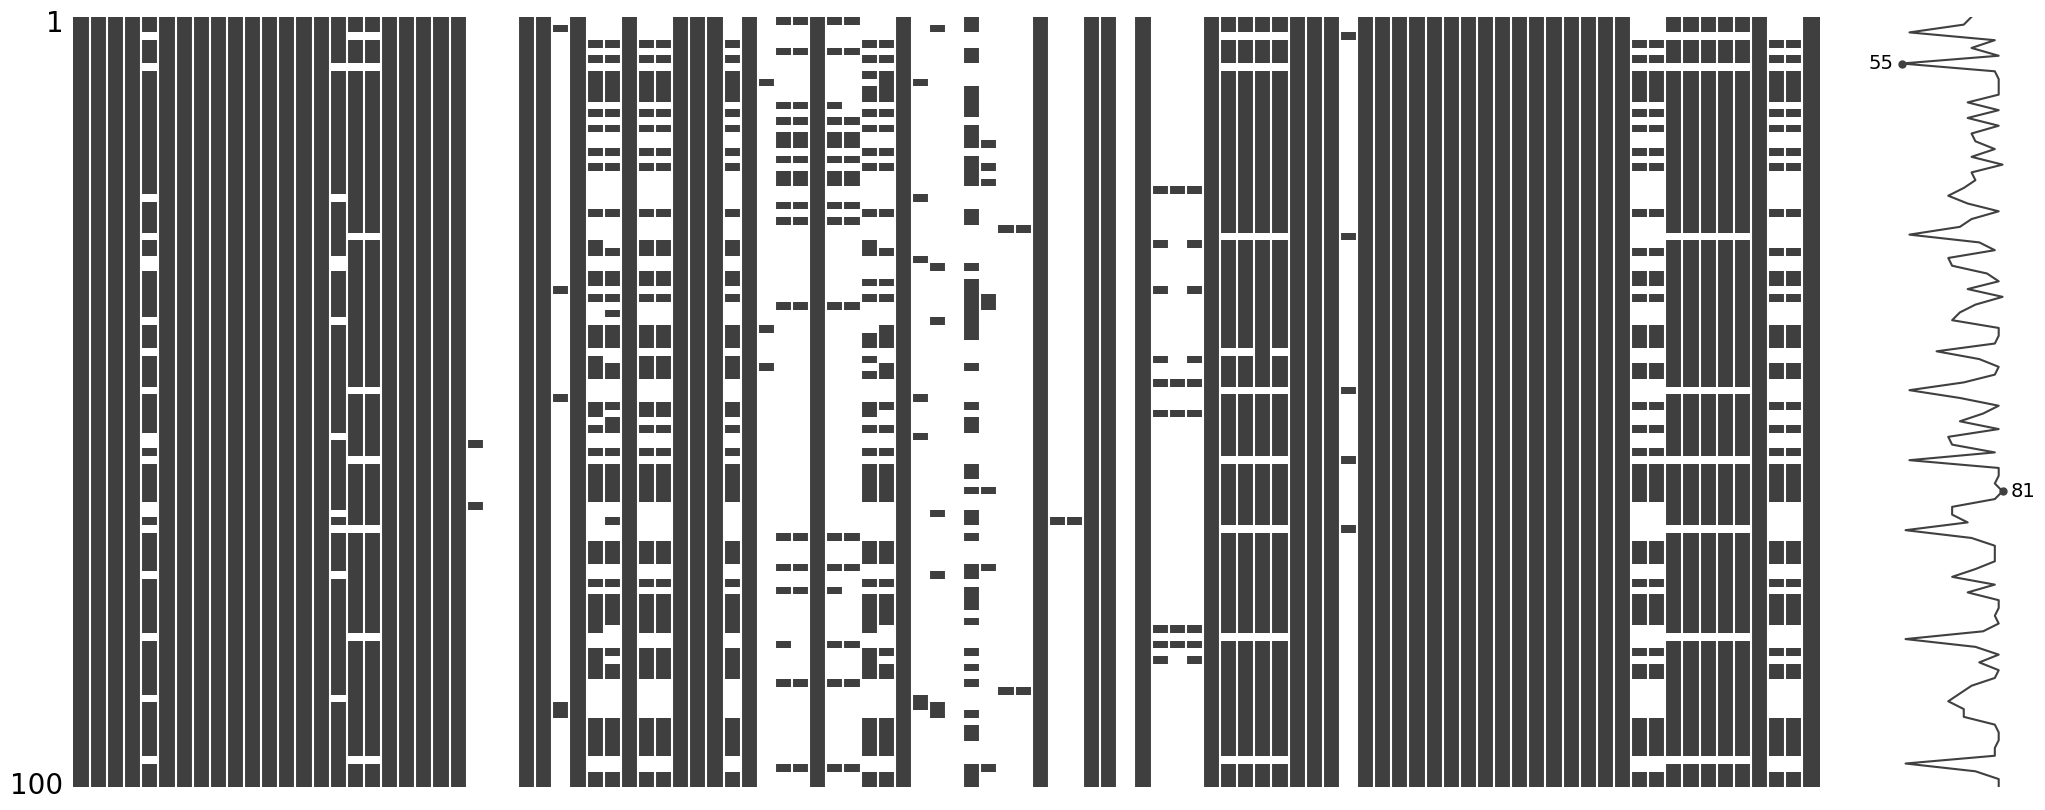

In [11]:
msno.matrix(systematic_sample(nfl_df, 100))

In [ ]:
msno.matrix(nfl_df)

In [ ]:
nfl_df_numerical = convert_categorical_to_numerical(nfl_df)
systematic_sample(nfl_df_numerical, 5)


In [ ]:
# Specify the label column
label_column = 'AQI_Bucket_Severe'

# Apply the function
X_train, Y_train = get_features_and_labels(city_day_df_numerical, label_column)
print(systematic_sample(X_train, 1))
print("-----------------------------")
print(systematic_sample(Y_train, 1))

In [ ]:
check_certain_model()

#  Melbourne Housing Snapshot

In [ ]:
melb_df = pd.read_csv("/kaggle/input/melbourne-housing-snapshot/melb_data.csv")

In [ ]:
systematic_sample(melb_df, 5)

In [ ]:
missing_values_table(melb_df)

In [ ]:
msno.matrix(systematic_sample(melb_df, 100))

In [ ]:
msno.matrix(melb_df)

# Melbourne Housing Market

In [ ]:
melb_housing_df = pd.read_csv("/kaggle/input/melbourne-housing-market/Melbourne_housing_FULL.csv")

In [ ]:
systematic_sample(melb_housing_df, 5)

In [ ]:
missing_values_table(melb_housing_df)

In [ ]:
msno.matrix(systematic_sample(melb_housing_df, 100))

In [ ]:
msno.matrix(melb_housing_df)

# House Prices - Advanced Regression Techniques

In [ ]:
housing_prices_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [ ]:
systematic_sample(housing_prices_df, 5)

In [ ]:
missing_values_table(housing_prices_df)

In [ ]:
msno.matrix(systematic_sample(housing_prices_df, 100))

In [ ]:
msno.matrix(housing_prices_df)

# Fatal Police Shootings in the US

In [ ]:
fatal_shootings_df = pd.read_csv("/kaggle/input/fatal-police-shootings-in-the-us/PoliceKillingsUS.csv", encoding='cp1252')

In [ ]:
systematic_sample(fatal_shootings_df, 5)

In [ ]:
missing_values_table(fatal_shootings_df)

In [ ]:
msno.matrix(systematic_sample(fatal_shootings_df, 100))

In [ ]:
msno.matrix(fatal_shootings_df)

# Water Quality

In [ ]:
water_quality_df = pd.read_csv("/kaggle/input/water-potability/water_potability.csv")

In [ ]:
systematic_sample(water_quality_df, 5)

In [ ]:
missing_values_table(water_quality_df)

In [ ]:
msno.matrix(systematic_sample(water_quality_df, 100))

In [ ]:
msno.matrix(water_quality_df)

# Palmer Penguins

In [ ]:
palmar_penguins = pd.read_csv("/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_lter.csv")

In [ ]:
systematic_sample(palmar_penguins, 5)

In [ ]:
missing_values_table(palmar_penguins)

In [ ]:
msno.matrix(systematic_sample(palmar_penguins, 100))

In [ ]:
msno.matrix(palmar_penguins)

# Austin Animal Center Shelter Outcomes

In [ ]:
austin_shelter_df = pd.read_csv("/kaggle/input/austin-animal-center-shelter-outcomes-and/aac_shelter_cat_outcome_eng.csv")

In [ ]:
systematic_sample(austin_shelter_df, 5)

In [ ]:
missing_values_table(austin_shelter_df)

In [ ]:
msno.matrix(systematic_sample(austin_shelter_df, 100))

In [ ]:
msno.matrix(austin_shelter_df)

# India Socio Economic Data

In [ ]:
india_df = pd.read_csv("/kaggle/input/all-census-data/elementary_2015_16.csv")

In [ ]:
systematic_sample(india_df, 5)

In [ ]:
missing_values_table(india_df)

In [ ]:
msno.matrix(systematic_sample(india_df, 100))

In [ ]:
msno.matrix(india_df)